In [1]:
# Import Libraries
import numpy as np

from project_utils.bb_model         import BB_Model
from project_utils.feature_stats    import Feature_Statistics
from project_utils.feature_stats    import Regression_Container
#from project_utils.acq_data_capture import Acq_Data_1D
from project_utils.surroagte_gp     import Surrogate_GP



Num_Points = 21


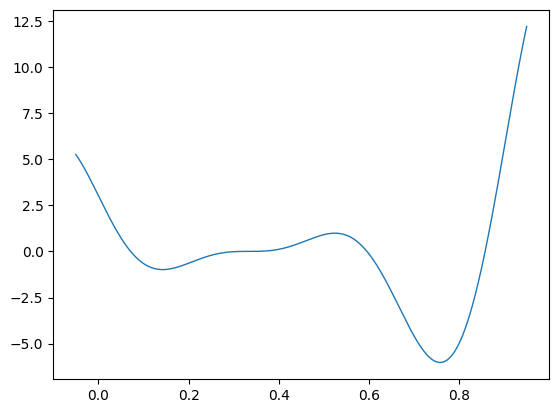

In [2]:
# Load Forrester model

Forrester_Data = BB_Model('Forrester')

#Forrester_Data.df().head()

In [3]:
Forrester_Data.MPL()

C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


0.10725130146139239


MLPRegressor(random_state=RandomState(MT19937) at 0x2A2DF629840)

In [4]:
Forrester_Data.Random_Forest()

0.9999081005612165


RandomForestRegressor(random_state=RandomState(MT19937) at 0x2A2DF629840)

In [5]:
Forrester_Data.GP()

0.9806944351731488


GaussianProcessRegressor()

In [6]:
print(Forrester_Data.get_features())

['X']


In [7]:
#Default settings
from unravel.tabular import UnRAVELTabularExplainer

X_train, X_test, y_train, y_test = Forrester_Data.get_TT_data()

#Initializing the explainer object
Unravel_Exp = UnRAVELTabularExplainer(bbox_model           = Forrester_Data.get_GP(),
                                      train_data           = X_train,
                                      categorical_features = Forrester_Data.get_catagorical(),
                                      mode                 = Forrester_Data.get_mode())

sur_GP = Surrogate_GP()


warning in stationary: failed to import cython module: falling back to numpy
warning in coregionalize: failed to import cython module: falling back to numpy
warning in choleskies: failed to import cython module: falling back to numpy


In [8]:
#Default settings
#from unravel_2.ur_model import UR_Model

#X_train, X_test, y_train, y_test = Forrester_Data.get_TT_data()


##Initializing the explainer object
#Unravel_Exp = UR_Model(bbox_model           = Forrester_Data.get_Random_Forest(),
#                       train_data           = X_train,
#                       categorical_features = Forrester_Data.get_catagorical(),
#                       mode                 = Forrester_Data.get_mode())       


In [9]:
mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)
print('Mean 0:', mean)
print('Std 0: ', std)


Mean 0: [0.44472375]
Std 0:  [0.28782013]


In [10]:
#for i in range(5):
#    print(X_test[i,:])

In [11]:
#from matplotlib import pyplot
#pyplot.boxplot(x=X_test)
#pyplot.show()

In [12]:
# Generate explantion data for Random Forest

Forrester_Stats = Feature_Statistics(feature_names = Forrester_Data.get_features(), mode = Forrester_Data.get_mode())

if Num_Points == 0: Num_Points = X_test.shape[0]

for test_instance in range(Num_Points):

    print('INSTANCE: ', test_instance)
       
#    data_row  = np.array([X_test[test_instance]])
    data_row  = np.array([0.05*test_instance])
    
    #scores, acq_data = Unravel_Exp.explain(X_init            = data_row.reshape(1, -1),
    scores = Unravel_Exp.explain(X_init            = data_row.reshape(1, -1),
                                 feature_names     = Forrester_Data.get_features(),
                                 alpha             = "FUR_W",
                                 max_iter          = 20,
                                 normalize         = False,
                                 interval          = 1,
                                 importance_method = "ARD")
       
    f_predict = Forrester_Data.get_Random_Forest().predict(data_row.reshape(1, -1))

    #e_predict = Unravel_Exp.gpmodel_predict(data_row)
    #e_predict = np.array(e_predict).ravel()
    
    acq_data = Unravel_Exp.get_acq_data()
    
    X, y = Unravel_Exp.get_surrogate_data()

    e_predict = sur_GP.predict(X, y)
#    e_predict = sur_GP.predict(Unravel_Exp.get_surrogate_data())

    print(f_predict, e_predict)
    
    Forrester_Stats.Add_Sample(sample_scores = scores,
                               outcome       = y_test[test_instance],
                               X_row         = data_row,
                               f_prediction  = f_predict,
                               e_prediction  = e_predict.ravel(),
                               feopt         = acq_data.get_fe_x0(),
                               model         = Unravel_Exp.get_gpmodel())


INSTANCE:  0
Acq_Data_1D
[2.37491608e+00 1.00000004e-05]
[3.0361245] [2.37491608e+00 1.00000004e-05]
INSTANCE:  1
Acq_Data_1D
[6.47247314e-01 1.00000004e-05]
[0.73476636] [6.47247314e-01 1.00000004e-05]
INSTANCE:  2
Acq_Data_1D
[-9.67636108e-02  1.00000004e-05]
[-0.65405927] [-9.67636108e-02  1.00000004e-05]
INSTANCE:  3
Acq_Data_1D
[-5.08636475e-01  9.99998931e-06]
[-0.97769519] [-5.08636475e-01  9.99998931e-06]
INSTANCE:  4
Acq_Data_1D
[-7.59704590e-01  1.00000004e-05]
[-0.64018627] [-7.59704590e-01  1.00000004e-05]
INSTANCE:  5
Acq_Data_1D
[-7.99415588e-01  1.00000004e-05]
[-0.20986436] [-7.99415588e-01  1.00000004e-05]
INSTANCE:  6
Acq_Data_1D
[-5.50209045e-01  1.00000004e-05]
[-0.01538083] [-5.50209045e-01  1.00000004e-05]
INSTANCE:  7
Acq_Data_1D
[-2.64816285e-02  1.00000004e-05]
[0.00185573] [-2.64816285e-02  1.00000004e-05]
INSTANCE:  8
Acq_Data_1D
[6.20010376e-01 9.99999486e-06]
[0.11539343] [6.20010376e-01 9.99999486e-06]
INSTANCE:  9
Acq_Data_1D
[1.12370300e+00 1.00000004e-0

In [13]:
import matplotlib.pyplot as plt


In [14]:
print(f_predict)
print(e_predict)


[12.09541408]
[2.14858170e+01 1.00000004e-05]


In [15]:
Forrester_Stats.Fidelity()

Average, Var, and Max Differences:
y - BB(x):           5.234217230842491  :  18.069516595242394  :  13.924322216246678
y - exp(x):          5.756458990536028  :  29.09547536986344  :  23.314725090989896
BB(x) - exp(x):      0.8914774154284036  :  3.6927996779896195  :  9.390402874743218
Average exp(x) var:  9.9998994257372e-06


In [16]:
#Forrester_Stats.Jaccard_Values()

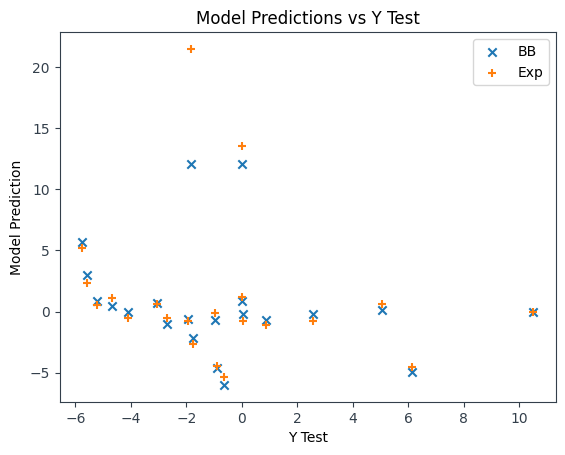

In [17]:
Forrester_Stats.Reg_Fidelity_Graph()

In [18]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern
from sklearn.gaussian_process.kernels import RBF

X, y = Unravel_Exp.get_surrogate_data()
kernel = Matern()

GP = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer = 10, optimizer='fmin_l_bfgs_b', normalize_y = False, copy_X_train=True)
GP.fit(X, y)
        
print(y[0])
fe = GP.predict(X[0].reshape(1,-1))
print(fe)
ey = Unravel_Exp.gpmodel_predict(X[0].reshape(1,-1))
print(ey)


[21.48581696]
[21.48581695]
(array([[0.41389117]]), array([[5.35036929e-05]]))


In [21]:

acq_data.Add_BB_model(Forrester_Data.get_Random_Forest())

In [22]:

acq_data.Create_BB_plot()

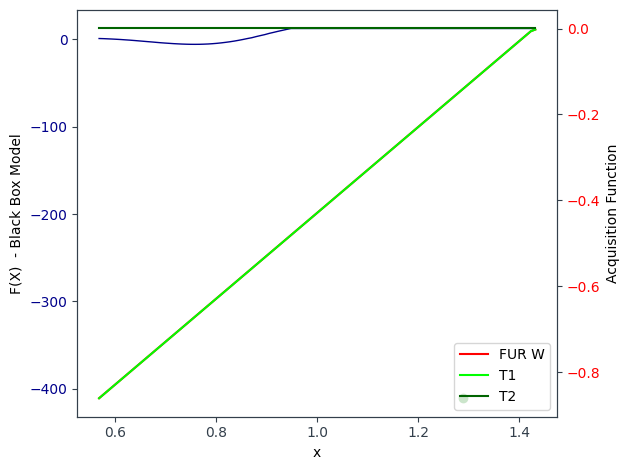

In [23]:
acq_data.plot_point(0)

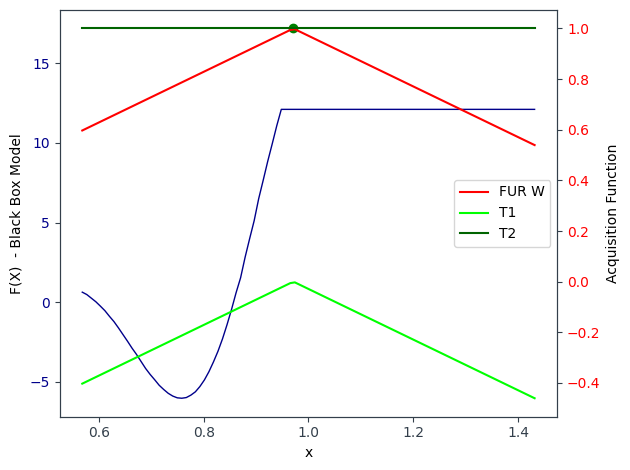

In [24]:
acq_data.plot_point(1)

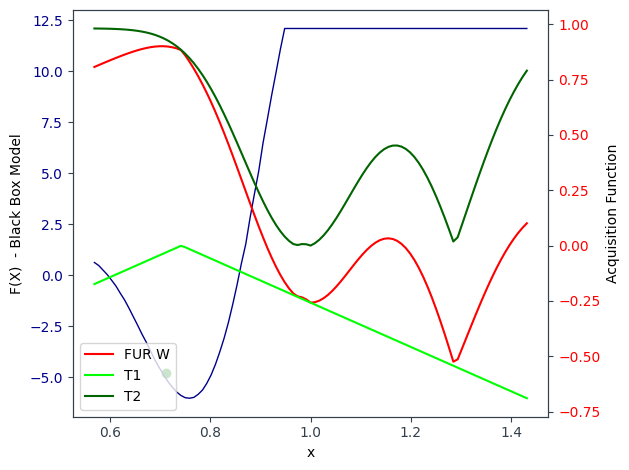

In [25]:
acq_data.plot_point(2)

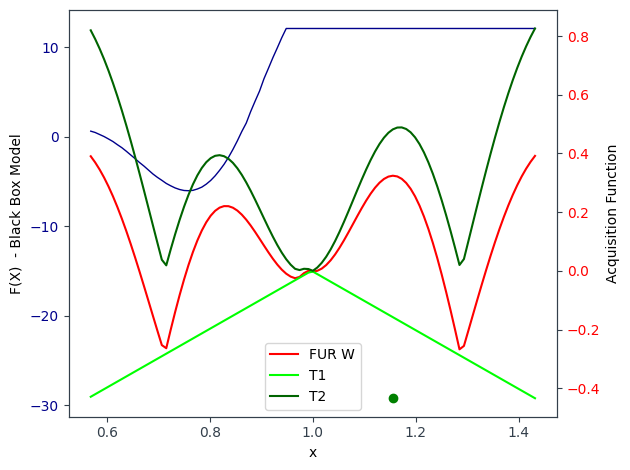

In [26]:
acq_data.plot_point(3)

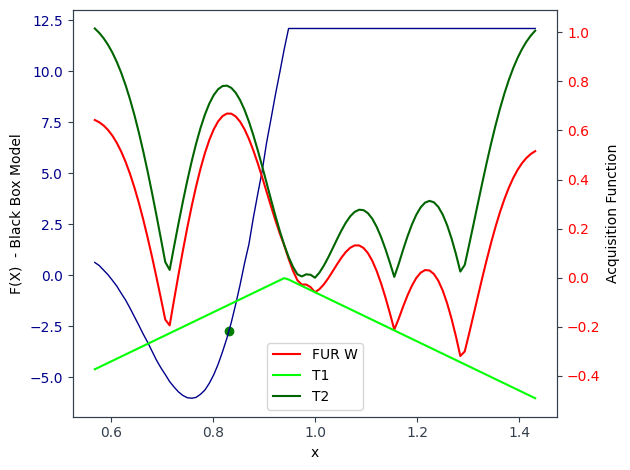

In [27]:
acq_data.plot_point(4)

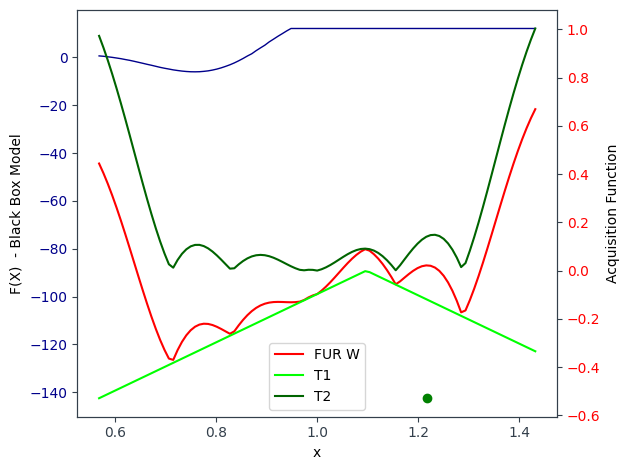

In [28]:
acq_data.plot_point(5)

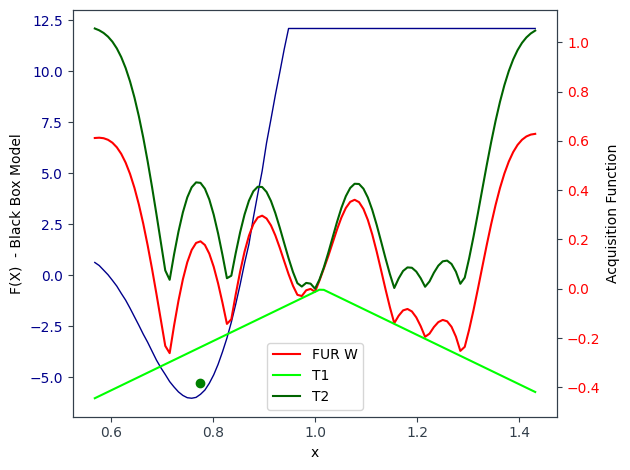

In [29]:
acq_data.plot_point(6)

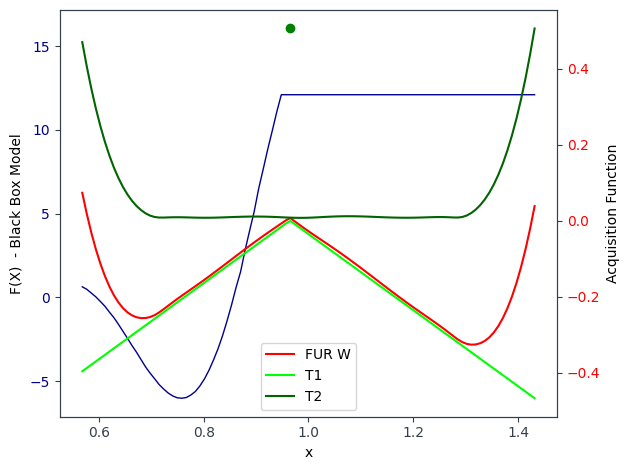

In [30]:
acq_data.plot_point(7)

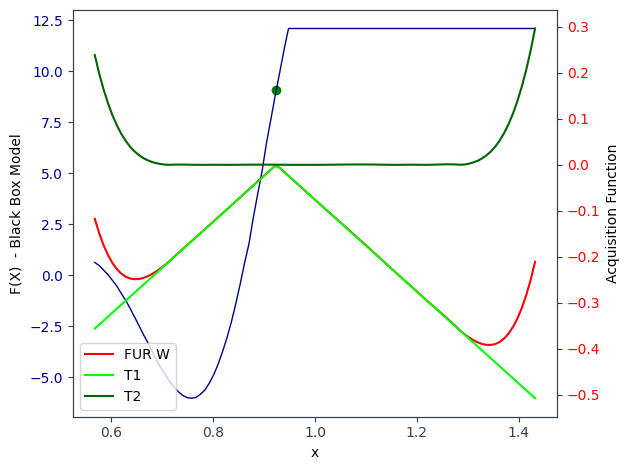

In [31]:
acq_data.plot_point(8)

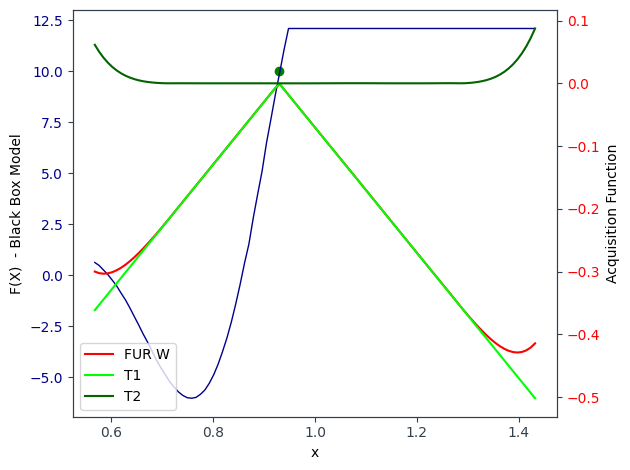

In [32]:
acq_data.plot_point(9)

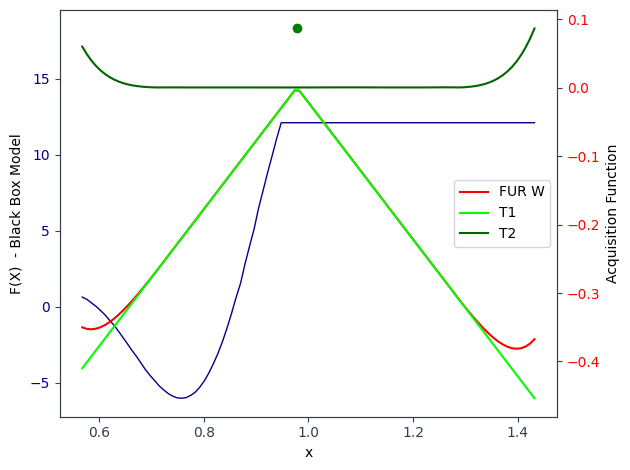

In [33]:
acq_data.plot_point(10)

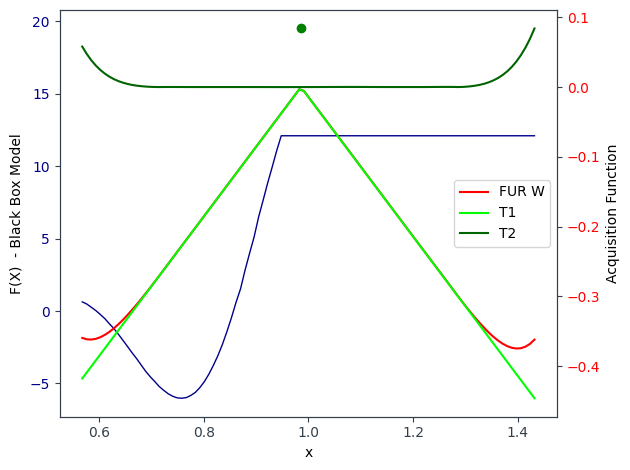

In [34]:
acq_data.plot_point(11)

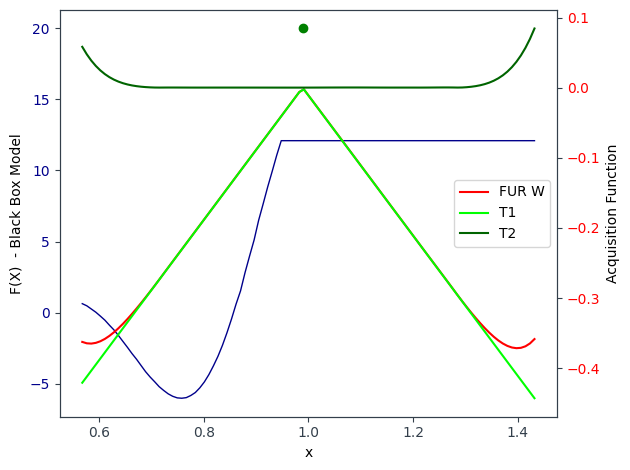

In [35]:
acq_data.plot_point(12)

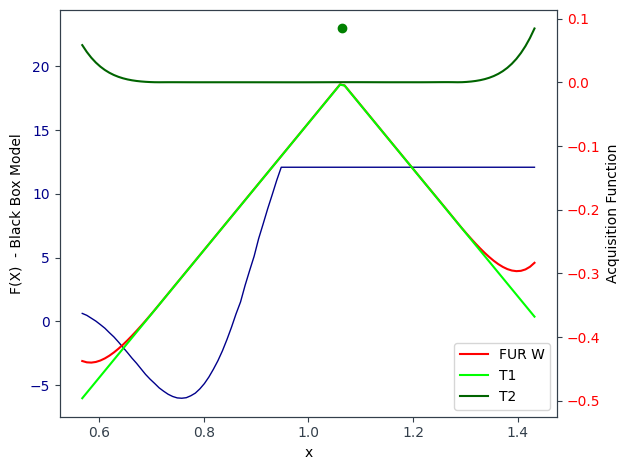

In [36]:
acq_data.plot_point(13)

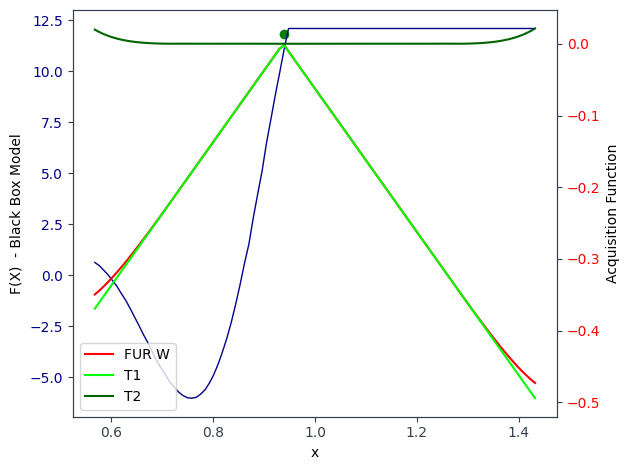

In [37]:
acq_data.plot_point(14)

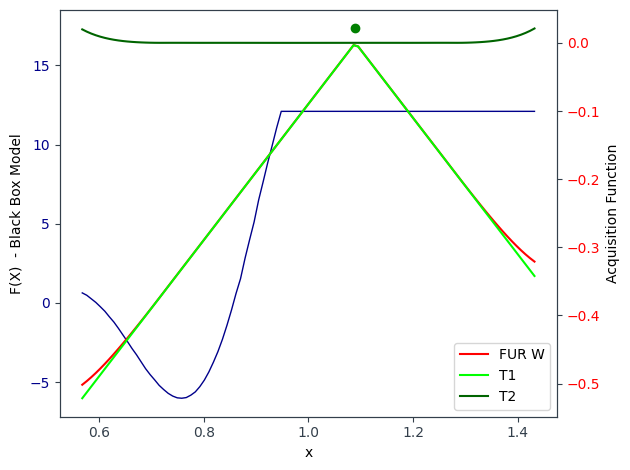

In [38]:
acq_data.plot_point(15)

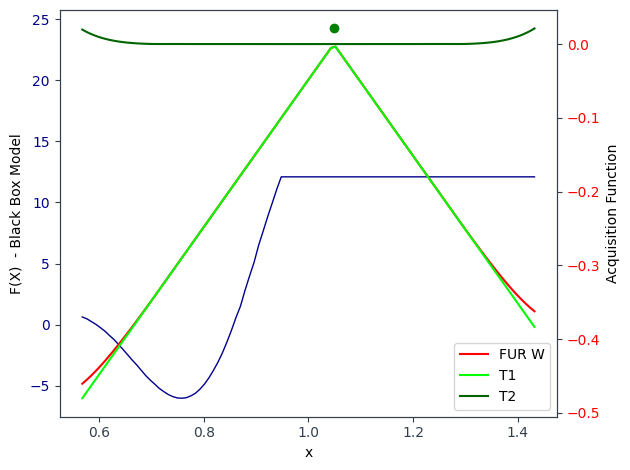

In [39]:
acq_data.plot_point(16)

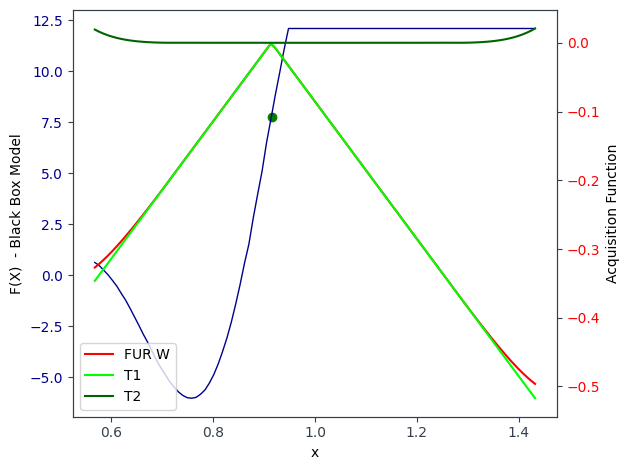

In [40]:
acq_data.plot_point(17)

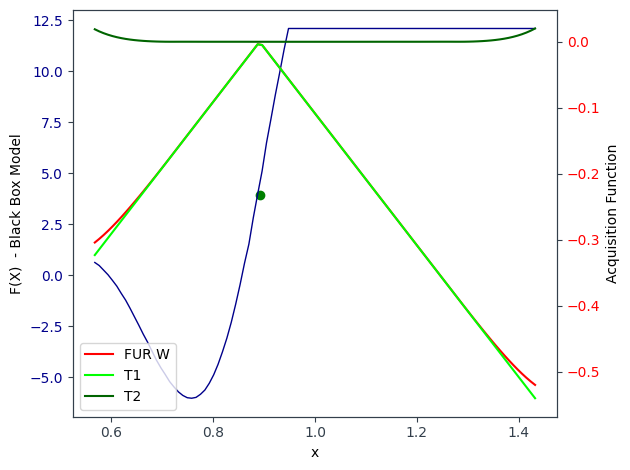

In [41]:
acq_data.plot_point(18)

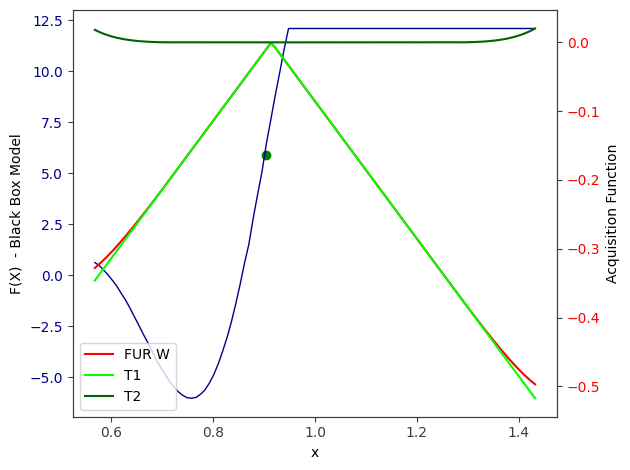

In [42]:
acq_data.plot_point(19)

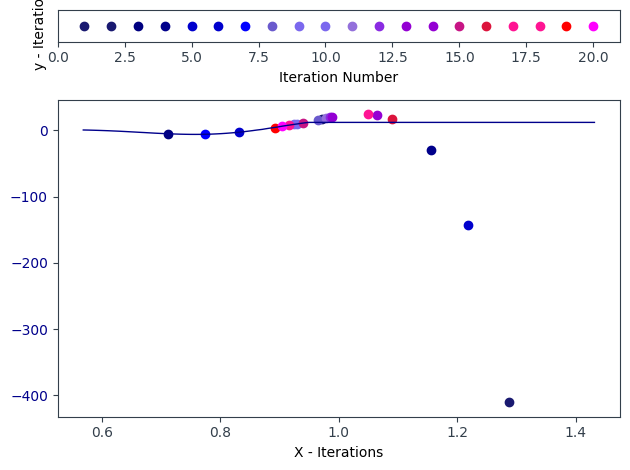

In [43]:
acq_data.plot_all()